In [80]:
import time
import torch as nn
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
from torch.nn.utils.rnn import pack_padded_sequence
import os
from scipy.misc import imread, imresize
from PIL import Image
from models import *
from datasets import *
from params import *
from utils import *
from torchsummary import summary
torch.manual_seed(0)


In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Declare Captioning without adversarial attack function

In [335]:
def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size):
    """
    Reads an image and captions it with beam search.

    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    # img = imresize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)

    prev_mean, prev_std = torch.empty(3), torch.empty(3)
    while(1):
        mean, std = img_mean_and_std(img, device)
        # print(mean, std)
        if (torch.sum(mean) == torch.sum(prev_mean) and torch.sum(std) == torch.sum(prev_std)):
            break
        else:
            prev_mean = mean
            prev_std = std

    
    normalize = transforms.Normalize(mean=mean,
                                     std=std)
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        # prev_word_inds = top_k_words / vocab_size  # (s)
        # prev_word_inds = torch.div(top_k_words, vocab_size) # (s)
        prev_word_inds = torch.div(top_k_words, vocab_size, rounding_mode='floor') # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas



### Declare Visualize Attention function

In [336]:
def visualize_att(image_path, output_path, seq, alphas, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.

    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

    # file name without extension
    plt.savefig(f'{os.path.splitext(output_path)[0]}.png', bbox_inches='tight')

In [337]:
def visualize_att_from_tensor(image_tensor, output_path, seq, alphas, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.

    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    resized_image = F.interpolate(image_tensor, [14 * 24, 14 * 24])
    image = resized_image.squeeze(0).permute(1,2,0).numpy() 
    # image = Image.open(image_path)
    # image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

    # file name without extension
    plt.savefig(f'{os.path.splitext(output_path)[0]}.png', bbox_inches='tight')

### Test Evaluation before Adversarial Attack

In [338]:
# Load word map (word2ix)
with open(data_word_map_file, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

# Training parameters
start_epoch = 1
epochs = 120  # number of epochs to train for (if early stopping is not triggered)
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
batch_size = 32
workers = 1  # for data-loading; right now, only 1 works with h5py
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.  # BLEU-4 score right now
recent_bleu4 = 0. # BLUE-4 score at last epoch
print_freq = 100  # print training/validation stats every __ batches
fine_tune_encoder = False  # fine-tune encoder? -> Change to True if training with different dataset

# Initialize model
decoder = DecoderWithAttention(attention_dim=attention_dim,
                                embed_dim=emb_dim,
                                decoder_dim=decoder_dim,
                                vocab_size=len(word_map),
                                dropout=dropout)
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                        lr=decoder_lr)

encoder = ResNet101Encoder()
encoder.fine_tune(fine_tune_encoder)
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                        lr=encoder_lr) if fine_tune_encoder else None

# Move to GPU, if available
decoder = decoder.to(device)
encoder = encoder.to(device)

# Load model
checkpoint = torch.load(data_best_checkpoint, map_location=str(device))

decoder.load_state_dict(checkpoint['decoder_state_dict'])
decoder.eval()
decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])

encoder.load_state_dict(checkpoint['encoder_state_dict'])
encoder.eval()    
if fine_tune_encoder is True:
    encoder.fine_tune(fine_tune_encoder)
    encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                            lr=encoder_lr)
    encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])




/scratch/ps4534/envs_dirs/kp/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/scratch/ps4534/envs_dirs/kp/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


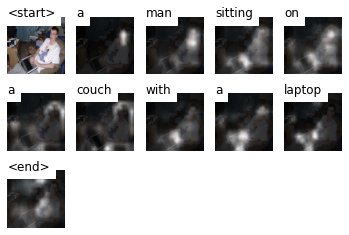

<Figure size 432x288 with 0 Axes>

In [387]:
# Encode, decode with attention and beam search
seq, alphas = caption_image_beam_search(encoder, decoder, "/scratch/ps4534/ml/image-captioning/img2.jpg", word_map, 3)
alphas = torch.FloatTensor(alphas)

# Visualize caption and attention of best sequence
visualize_att("/scratch/ps4534/ml/image-captioning/img2.jpg", "/scratch/ps4534/ml/image-captioning/img2_caption.png", seq, alphas, rev_word_map, False)

### ATTACK CODE BEGIN HERE

In [340]:
# Loss function
criterion = nn.CrossEntropyLoss().to(device)

### Declare captioning with adversarial attack function

In [341]:
# get caption after adversarial attack
def caption_image_beam_search_for_perturbed_image(decoder, purterbed_image, word_map, beam_size):
    k = beam_size # beam_size
    vocab_size = len(word_map)

    # Encode, we've already encode the image :)
    encoder_out = encoder(purterbed_image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    # encoder_out = purterbed_image # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k (beam_size)
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)
    # if beam size = 3
    # 1 <start>
    # 2 <start>
    # 3 <start>

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        # prev_word_inds = top_k_words / vocab_size  # (s)
        # prev_word_inds = torch.div(top_k_words, vocab_size) # (s)
        prev_word_inds = torch.div(top_k_words, vocab_size, rounding_mode='floor') # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                                dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                            next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]
    
    return seq, alphas

### Declare Untargeted Fast Gradient Signed Method Function

In [342]:
def UFGSM(image, eps, signed_grad): #Untargeted FGSM
        # we can add "create adversarial pattern" function here
        perturbed_image = image + (eps*signed_grad) # Untargeted / Gradient ascent / Move away from minima
        perturbed_image = torch.clamp(perturbed_image , 0, 1) # Might need clipping after addition / subtraction
        return perturbed_image

### DRAFT PGD

In [343]:
def PGD(image, eps, iter, predictor_model):
    # Load image to tensor
    # image = tf.convert_to_tensor(image)
    # Clip eta to eps (norm ball infinity)
    eta = torch.zeros(eta, -eps, eps).to(device)
    adv_image = image + eta

    for i in range(iter):
        # FGSM begins here
        (img, ori_img, signed_grad, image_size) = create_adversarial_pattern_from_tensor(
                        adv_image=adv_image,
                        caps=caption,
                        caplens=caption_length,
                        encoder=encoder,
                        encoder_optimizer=encoder_optimizer,
                        decoder=decoder,
                        decoder_optimizer=decoder_optimizer,
                        criterion=criterion)
        adv_image = UFGSM(adv_image, eps, signed_grad)
        # FGSM ends here

        # Clipping perturbation eta to norm ball
        eta = adv_image - image
        eta = torch.clamp(eta , -eps, eps)
        adv_image = image + eta

        # Redo the clipping.
        # FGM already did it, but subtracting and re-adding eta can add some
        adv_image = torch.clamp(adv_image , -1, 1)

### Declare Targeted Fast Gradient Signed Method Function

In [344]:
def TFGSM(image, eps, signed_grad): #Untargeted FGSM
        # we can add "create adversarial pattern" function here
        perturbed_image = image - (eps*signed_grad) # Targeted / Gradient descent to targeted signed gradient
        perturbed_image = torch.clamp(perturbed_image , 0, 1) # Might need clipping after addition / subtraction
        return perturbed_image

### Declare Create Adversarial Pattern From Image Function

In [388]:
def create_adversarial_pattern_from_image(image_path, caps, caplens, encoder, encoder_optimizer, decoder, decoder_optimizer, criterion):
    """
    Generate adversarial pattern from an image
    :param image_path: path to input image
    :param caps: processed input caption by user
    :param caplens: length of input caption
    :param encoder: encoder model
    :param encoder_optimizer: encoder optimizer
    :param decoder: decoder model
    :param decoder_optimizer: encoder optimizer
    :param criterion: loss layer
    :return: BLEU-4 score
    :return: encoded image tensor, original image tensor, signs of gradients w.r.t to input image, size of input image
    """
    decoder.train() # For gradient calculation during validation
    if encoder is not None:
        encoder.eval() # eval mode (no dropout or batchnorm)

    # Read image and process
    img = imread(image_path)
    # image_size = [(sub[1], sub[0]) for sub in [img.shape[0:2]]][0]
    image_size = img.shape[0:2]
    print(image_size)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = imresize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.


    # Move to device, if available
    img = torch.FloatTensor(img).to(device)
    ori_img = img
    caps = torch.LongTensor(caps).to(device)
    caplens = torch.LongTensor([caplens]).to(device)
    
    # Normalize input image
    prev_mean, prev_std = torch.empty(3), torch.empty(3)
    while(1):
        mean, std = img_mean_and_std(img, device)
        # print(mean, std)
        if (torch.sum(mean) == torch.sum(prev_mean) and torch.sum(std) == torch.sum(prev_std)):
            break
        else:
            prev_mean = mean
            prev_std = std
            
    normalize = transforms.Normalize(mean=mean,
                                     std=std)
    transform = transforms.Compose([normalize])
    img = transform(img)  # (3, 256, 256)
    
    # reshape 3 dimension input tensor to 4 dimension
    img = img.unsqueeze(0) # (1, 3, 256, 256)

    # reshape 1 dimension input caption to 2 dimension
    if caps.dim() == 1:
        caps = caps.unsqueeze(0) # (1, caption_size)

    print(caplens.shape)

    # Prepare for gradient calculation of loss w.r.t to the input image.
    img.requires_grad = True # *Adversarial Attack*
    
    # Forward propagation through encoder
    if encoder is not None:
        encoded_img = encoder(img)
    # summary(decoder, (encoded_img, caps, caplens))
    
    # Forward propagation through decoder
    scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(encoded_img, caps, caplens)

    # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
    targets = caps_sorted[:, 1:]

    print(targets)

    # Remove timesteps that we didn't decode at, or are pads
    # pack_padded_sequence is an easy trick to do this
    scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
    targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data
    
    # Calculate loss
    loss = criterion(scores, targets)

    # Add doubly stochastic attention regularization
    loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
    
    # Clean optimizers' gradients
    decoder_optimizer.zero_grad()
    if encoder_optimizer is not None:
        encoder_optimizer.zero_grad()

    # Back propagation for *Adversarial Attack*
    img.retain_grad() # Explicitly allow leaf node (input) calculation
    loss.backward() # Calculates imgs.grad = d-loss/d-imgs for every imgs with imgs.requires_grad=True
    
    # Result of back propagation
    gradient = img.grad

    # Getting gradient sign (+,-) for adversarial perturbation
    signed_grad = torch.sign(gradient)
    
    # Stopping gradient calculation of input and gradient sign
    img = img.detach()
    signed_grad = signed_grad.detach()

    # Denormalize input gradient
    # inv_mean = [1/x for x in mean]
    # inv_std = [-x for x in std]
    # invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
    #                                                     std = inv_std),
    #                                 transforms.Normalize(mean = inv_mean,
    #                                                     std = [ 1., 1., 1. ]),
    #                             ])
    # signed_grad = invTrans(signed_grad)

    return img, ori_img, signed_grad, image_size


### Begin Untargeted attack from image

In [ ]:
# caption_length = [16, 14, 11, 20, 31]
# caption = [[9488, 1, 2, 3, 1, 4, 5, 6, 1, 7, 8, 6, 1, 9, 10, 9489, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [9488, 2, 11, 1, 12, 13, 6, 1, 9, 10, 6, 14, 15, 9489, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [9488, 1, 2, 11, 6, 14, 16, 17, 1, 18, 9489, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [9488, 1, 2, 32, 1, 4, 33, 28, 1, 4, 34, 35, 6, 1, 18, 6, 1, 36, 37, 9489, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [9488, 1, 9, 19, 3, 1, 20, 21, 6, 1, 12, 13, 22, 23, 14, 24, 17, 1, 25, 26, 3, 1, 27, 28, 1, 29, 17, 30, 9487, 31, 9489, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
# words = [rev_word_map[ind] for ind in caption[0]]
# print(words)
# words = [rev_word_map[ind] for ind in caption[1]]
# print(words)
# words = [rev_word_map[ind] for ind in caption[2]]
# print(words)
# words = [rev_word_map[ind] for ind in caption[3]]
# print(words)
# words = [rev_word_map[ind] for ind in caption[4]]
# print(words)

# caption_length = [6]
# caption = [9488, 3, 1, 4, 5,  9489, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# words = [rev_word_map[ind] for ind in caption]
# print(words)




# caption_length = [16]
# caption = [9488, 1, 2, 3, 1, 4, 5, 6, 1, 7, 8, 6, 1, 9, 10, 9489, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# words = [rev_word_map[ind] for ind in caption]
# print(words)


In [393]:
words = [word_map[ind] for ind in ["a", "young", "boy", "stares", "up", "at", "the", "computer", "monitor"]]
print(words)

[1, 20, 64, 85, 86, 79, 14, 74, 80]


['<start>', 'a', 'young', 'boy', 'stares', 'up', 'at', 'the', 'computer', 'monitor', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


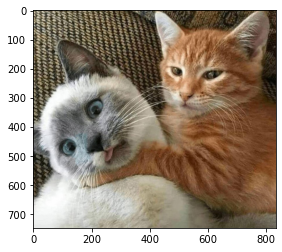

In [394]:
# image_path = "/scratch/ps4534/ml/image-captioning/COCO_val2014_000000391895.jpg"
image_path = "/scratch/ps4534/ml/image-captioning/cat2.jpg"
# image_path = "/scratch/ps4534/ml/image-captioning/img2.jpg"

caption_length = [16]
caption = [9488, 1, 20, 64, 85, 86, 79, 14, 74, 80, 9489, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
words = [rev_word_map[ind] for ind in caption]
print(words)

image_from_path = Image.open(image_path)
plt.imshow(image_from_path)


### Generate adversarial gradients

In [395]:
img, ori_img, signed_grad, image_size = create_adversarial_pattern_from_image(image_path=image_path,
                        caps=caption,
                        caplens=caption_length,
                        encoder=encoder,
                        encoder_optimizer=encoder_optimizer,
                        decoder=decoder,
                        decoder_optimizer=decoder_optimizer,
                        criterion=criterion)
image_size

/scratch/ps4534/envs_dirs/kp/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/scratch/ps4534/envs_dirs/kp/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


(748, 834)
torch.Size([1, 1])
tensor([[   1,   20,   64,   85,   86,   79,   14,   74,   80, 9489,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0]])


(748, 834)

### Launch UFGSM attack using the gradients

In [398]:
# imgs.shape, signed_grads.shape
# img =  torch.clamp(img , 0, 1)
# perturbed_img = UFGSM(img, 25/255, signed_grad)
epsilon = 20/255
perturbed_img = UFGSM(ori_img, epsilon, signed_grad)

# image = img
image = img
ori_image = ori_img.unsqueeze(0)
perturbed_image = perturbed_img
signed_gradient = signed_grad

# imgs[0].shape, perturbed_imgs[0].shape
image.shape, perturbed_image.shape, signed_gradient.shape

(torch.Size([1, 3, 256, 256]),
 torch.Size([1, 3, 256, 256]),
 torch.Size([1, 3, 256, 256]))

['<start>', 'a', 'close', 'up', 'of', 'a', 'cat', 'laying', 'on', 'a', 'couch', '<end>']


/scratch/ps4534/envs_dirs/kp/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


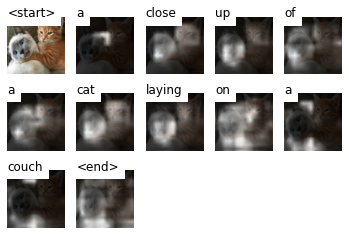

['<start>', 'a', 'white', 'cat', 'is', 'laying', 'on', 'a', 'bed', '<end>']


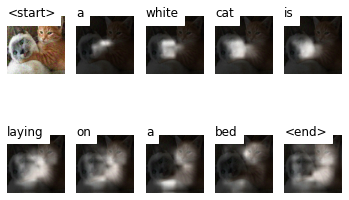

<Figure size 432x288 with 0 Axes>

In [399]:
# normalize = transforms.Normalize(mean=data_test_mean,
#                                     std=data_train_mean)
# transform = transforms.Compose([normalize])
# norm_image = transform(image)  # (3, 256, 256)
# norm_perturned_image = transform(perturbed_image)

# seq, alphas = caption_image_beam_search(encoder, decoder, image_path, word_map, 3)
seq, alphas = caption_image_beam_search_for_perturbed_image(decoder, image, word_map, 3)
alphas = torch.FloatTensor(alphas)
words = [rev_word_map[ind] for ind in seq]
print(words)
# Visualize caption and attention of best sequence
visualize_att_from_tensor(ori_image, "/scratch/ps4534/ml/image-captioning/before_attack.png", seq, alphas, rev_word_map, False)
# visualize_att(image_path, "/scratch/ps4534/ml/image-captioning/before_attack.png", seq, alphas, rev_word_map, False)

seq, alphas = caption_image_beam_search_for_perturbed_image(decoder, perturbed_image, word_map, 3)
alphas = torch.FloatTensor(alphas)
words = [rev_word_map[ind] for ind in seq]
print(words)
# Visualize caption and attention of best sequence
visualize_att_from_tensor(perturbed_image, "/scratch/ps4534/ml/image-captioning/after_attack.png", seq, alphas, rev_word_map, False)

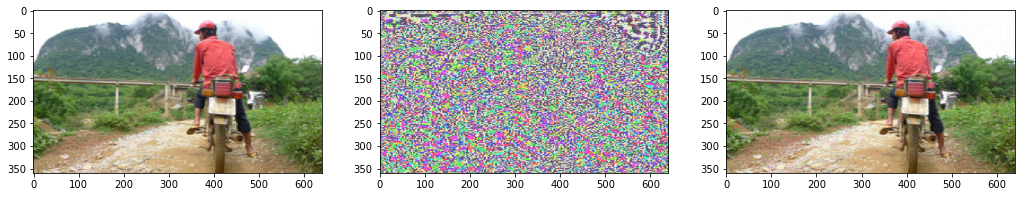

In [368]:
resized_image = F.interpolate(ori_image, image_size)
resized_perturbed_image = F.interpolate(perturbed_image, image_size)
resized_signed_gradient = F.interpolate(signed_gradient, image_size)
tmp_image = resized_image.squeeze(0).permute(1,2,0).numpy() 
tmp_purturbed_image = resized_perturbed_image.squeeze(0).permute(1,2,0).numpy()
tmp_signed_gradient = resized_signed_gradient.squeeze(0).permute(1,2,0).numpy()
plt.figure(figsize=(30,20))
plt.subplot(2,5,1)
plt.imshow(tmp_image)
plt.subplot(2,5,2)
plt.imshow((tmp_signed_gradient) * 0.5 + 0.5)
plt.subplot(2,5,3)
plt.imshow((tmp_purturbed_image))


### Targeted attack from an image

In [369]:
image_path = "/scratch/ps4534/ml/image-captioning/COCO_val2014_000000391895.jpg"

caption_length = [16]
# caption = [9488, 1, 38, 3, 1, 4, 5, 6, 1, 7, 8, 6, 1, 9, 10, 9489, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
caption = [9488, 0, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9489, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

words = [rev_word_map[ind] for ind in caption]
print(words)

['<start>', '<pad>', 'woman', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [370]:
img, ori_img, signed_grad, image_size = create_adversarial_pattern_from_image(image_path=image_path,
                        caps=caption,
                        caplens=caption_length,
                        encoder=encoder,
                        encoder_optimizer=encoder_optimizer,
                        decoder=decoder,
                        decoder_optimizer=decoder_optimizer,
                        criterion=criterion)
image_size

/scratch/ps4534/envs_dirs/kp/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/scratch/ps4534/envs_dirs/kp/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


(360, 640)
torch.Size([1, 1])
tensor([[   0,   38,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0, 9489,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0]])


(360, 640)

In [371]:
# imgs.shape, signed_grads.shape
# img =  torch.clamp(img , 0, 1)
# perturbed_img = UFGSM(img, 25/255, signed_grad)
epsilon = 10/255
perturbed_img = TFGSM(ori_img, epsilon, signed_grad)

# image = img
image = img
ori_image = ori_img.unsqueeze(0)
perturbed_image = perturbed_img
signed_gradient = signed_grad

# imgs[0].shape, perturbed_imgs[0].shape
image.shape, perturbed_image.shape, signed_gradient.shape

(torch.Size([1, 3, 256, 256]),
 torch.Size([1, 3, 256, 256]),
 torch.Size([1, 3, 256, 256]))

['<start>', 'a', 'man', 'in', 'a', 'red', 'jacket', 'is', 'riding', 'a', 'bicycle', '<end>']


/scratch/ps4534/envs_dirs/kp/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


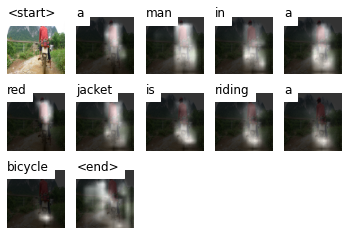

['<start>', 'a', 'woman', 'in', 'a', 'pink', 'dress', 'is', 'standing', 'on', 'a', 'dirt', 'road', '<end>']


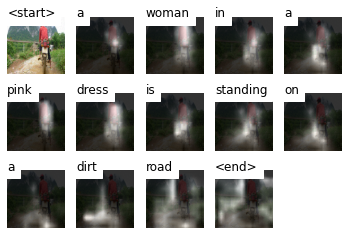

<Figure size 432x288 with 0 Axes>

In [372]:
# normalize = transforms.Normalize(mean=data_test_mean,
#                                     std=data_train_mean)
# transform = transforms.Compose([normalize])
# norm_image = transform(image)  # (3, 256, 256)
# norm_perturned_image = transform(perturbed_image)

# seq, alphas = caption_image_beam_search(encoder, decoder, image_path, word_map, 3)
seq, alphas = caption_image_beam_search_for_perturbed_image(decoder, image, word_map, 3)
alphas = torch.FloatTensor(alphas)
words = [rev_word_map[ind] for ind in seq]
print(words)
# Visualize caption and attention of best sequence
visualize_att_from_tensor(ori_image, "/scratch/ps4534/ml/image-captioning/before_attack.png", seq, alphas, rev_word_map, False)
# visualize_att(image_path, "/scratch/ps4534/ml/image-captioning/before_attack.png", seq, alphas, rev_word_map, False)

seq, alphas = caption_image_beam_search_for_perturbed_image(decoder, perturbed_image, word_map, 3)
alphas = torch.FloatTensor(alphas)
words = [rev_word_map[ind] for ind in seq]
print(words)
# Visualize caption and attention of best sequence
visualize_att_from_tensor(perturbed_image, "/scratch/ps4534/ml/image-captioning/after_attack.png", seq, alphas, rev_word_map, False)

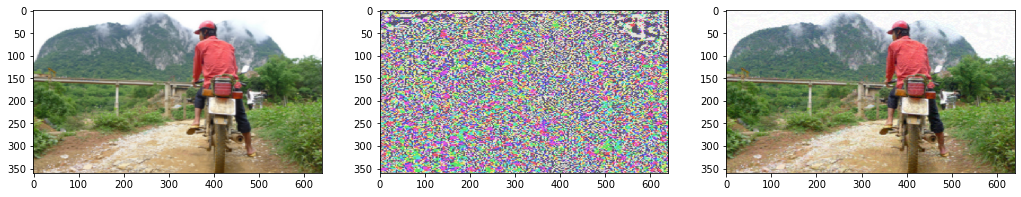

In [373]:
resized_image = F.interpolate(ori_image, image_size)
resized_perturbed_image = F.interpolate(perturbed_image, image_size)
resized_signed_gradient = F.interpolate(signed_gradient, image_size)
tmp_image = resized_image.squeeze(0).permute(1,2,0).numpy() 
tmp_purturbed_image = resized_perturbed_image.squeeze(0).permute(1,2,0).numpy()
tmp_signed_gradient = resized_signed_gradient.squeeze(0).permute(1,2,0).numpy()
plt.figure(figsize=(30,20))
plt.subplot(2,5,1)
plt.imshow(tmp_image)
plt.subplot(2,5,2)
plt.imshow((tmp_signed_gradient) * 0.5 + 0.5)
plt.subplot(2,5,3)
plt.imshow((tmp_purturbed_image))


### Untargeted attack from dataloader

In [400]:

# Custom dataloaders
attack_normalize = transforms.Compose([transforms.Normalize(mean=data_test_mean, std=data_test_std)])
# attack_normalize = None

attack_loader = torch.utils.data.DataLoader(
    CaptionDataset(data_folder, data_name, 'TEST', transform=attack_normalize),
    batch_size=1, shuffle=True, num_workers=workers, pin_memory=True)


tensor([480, 640])
['<start>', 'a', 'bowl', 'of', 'apples', 'next', 'to', 'three', 'partially', 'peeled', 'ones', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


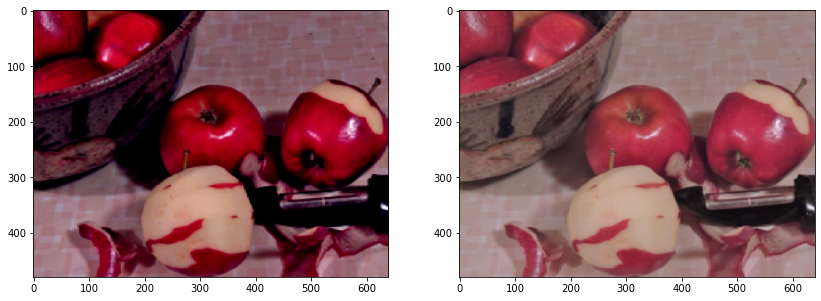

In [401]:
inv_data_test_mean = [1/x for x in data_test_mean]
inv_data_test_std = [-x for x in data_test_std]
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                    std = inv_data_test_mean),
                                transforms.Normalize(mean = inv_data_test_std,
                                                    std = [ 1., 1., 1. ]),
                            ])



for i, (imgs, ori_imgs, image_sizes, caps, caplens, allcaps) in enumerate(attack_loader):
    imgs2 = torch.clamp(invTrans(imgs[0]), 0, 1)
    imgs2 = torch.clamp(imgs2, 0, 1)
    ori_imgs2 = torch.clamp(ori_imgs[0], 0, 1)
    # print(ori_images[0].shape)
    imgs2 = F.interpolate(imgs2.unsqueeze(0), tuple(image_sizes[0].numpy()))
    ori_imgs2 = F.interpolate(ori_imgs2.unsqueeze(0), tuple(image_sizes[0].numpy()))
    imgs2 = imgs2.squeeze(0).permute(1,2,0).numpy()
    ori_imgs2 = ori_imgs2.squeeze(0).permute(1,2,0).numpy()
    plt.figure(figsize=(14,7))
    plt.subplot(1,2,1)
    plt.imshow((imgs2))
    plt.subplot(1,2,2)
    plt.imshow((ori_imgs2))
    words = [rev_word_map[ind] for ind in caps[0].numpy()]
    print(image_sizes[0])
    print(words)
    if i >= 0:
        break


In [382]:
def create_adversarial_pattern_from_loader(attack_loader, encoder, encoder_optimizer, decoder, decoder_optimizer, criterion):
    """
    Performs one epoch's validation.

    :param attack_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.train() # For gradient calculation during validation
    if encoder is not None:
        encoder.eval() # eval mode (no dropout or batchnorm)

    # Initialize timer
    if device.type == 'cuda':
        start = torch.cuda.Event(enable_timing=True)
        start.record()
        end = torch.cuda.Event(enable_timing=True)  
    else:
        start = time.perf_counter()
 
    # Batches
    for i, (imgs, ori_imgs, image_sizes, caps, caplens, allcaps) in enumerate(attack_loader):

        # Move to device, if available
        ori_imgs = ori_imgs.to(device)
        imgs = imgs.to(device)
        caps = caps.to(device)
        print(caps)
        print(caps.shape)
        caplens = caplens.to(device)
        print(caplens)
        print(caplens.shape)
        # Prepare for gradient calculation of loss w.r.t to the input image.
        imgs.requires_grad = True # *Adversarial Attack*
        
        # Forward propagation through encoder
        if encoder is not None:
            encoded_imgs = encoder(imgs)
        
        # Forward propagation through decoder
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(encoded_imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data
        
        # Calculate loss
        loss = criterion(scores, targets)

        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
        
        # Clean optimizers' gradients
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()

        # Back propagation for *Adversarial Attack*
        imgs.retain_grad() # Explicitly allow leaf node (input) calculation
        loss.backward() # Calculates img.grad = d-loss/d-img for every img with img.requires_grad=True
        
        # Result of back propagation
        gradients = imgs.grad

        # Getting gradient sign (+,-) for adversarial perturbation
        signed_grads = torch.sign(gradients)
        
        # Stopping gradient calculation of input and gradient sign
        imgs = imgs.detach()
        signed_grads = signed_grads.detach()

        # Denormalize input images
        inv_data_test_mean = [1/x for x in data_test_mean]
        inv_data_test_std = [-x for x in data_test_std]
        invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                            std = inv_data_test_mean),
                                        transforms.Normalize(mean = inv_data_test_std,
                                                            std = [ 1., 1., 1. ]),
                                    ])
        signed_grads = invTrans(signed_grads)

        return imgs, ori_imgs, signed_grads, image_sizes


In [383]:
# One epoch's validation
imgs, ori_images, signed_grads, image_sizes = create_adversarial_pattern_from_loader(attack_loader=attack_loader,
                        encoder=encoder,
                        encoder_optimizer=encoder_optimizer,
                        decoder=decoder,
                        decoder_optimizer=decoder_optimizer,
                        criterion=criterion)

tensor([[9488,   14,   21,  359,    1,   18,  381,  391, 1221, 9489,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]])
torch.Size([1, 52])
tensor([[10]])
torch.Size([1, 1])


In [384]:
# imgs.shape, signed_grads.shape

# imgs =  torch.clamp(imgs , 0, 1)
epsilon = 5/255
perturbed_imgs = UFGSM(ori_images, epsilon, signed_grads)

image = ori_images[0].unsqueeze(0)
perturbed_image = perturbed_imgs[0].unsqueeze(0)
signed_gradient = signed_grads[0].unsqueeze(0)

# imgs[0].shape, perturbed_imgs[0].shape
# image.shape, perturbed_image.shape, signed_gradient.shape

In [385]:
# normalize = transforms.Normalize(mean=data_test_mean,
#                                     std=data_train_mean)
# transform = transforms.Compose([normalize])
# norm_image = transform(image)  # (3, 256, 256)
# norm_perturned_image = transform(perturbed_image)
seq, alphas = caption_image_beam_search_for_perturbed_image(decoder, image, word_map, 3)


words = [rev_word_map[ind] for ind in seq]
print(words)

seq, alphas = caption_image_beam_search_for_perturbed_image(decoder, perturbed_image, word_map, 3)
words = [rev_word_map[ind] for ind in seq]
print(words)

['<start>', 'a', 'group', 'of', 'people', 'riding', 'motorcycles', 'down', 'a', 'street', '<end>']
['<start>', 'a', 'group', 'of', 'people', 'walking', 'down', 'a', 'street', '<end>']


(640, 427)


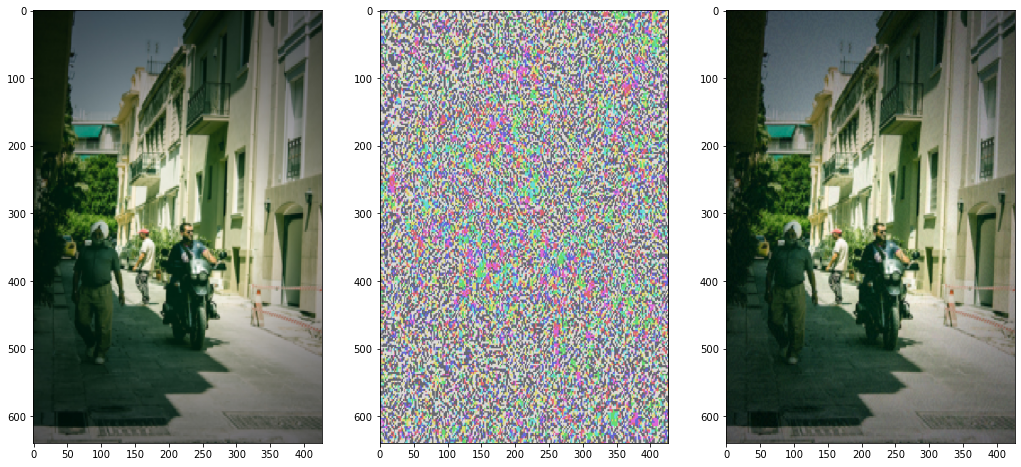

In [386]:
print(tuple(image_sizes[0].numpy()))
resized_image = F.interpolate(image, tuple(image_sizes[0].numpy()))
resized_perturbed_image = F.interpolate(perturbed_image, tuple(image_sizes[0].numpy()))
resized_signed_gradient = F.interpolate(signed_gradient, tuple(image_sizes[0].numpy()))
tmp_image = resized_image.squeeze(0).permute(1,2,0).numpy() 
tmp_purturbed_image = resized_perturbed_image.squeeze(0).permute(1,2,0).numpy()
tmp_signed_gradient = resized_signed_gradient.squeeze(0).permute(1,2,0).numpy()
plt.figure(figsize=(30,20))
plt.subplot(2,5,1)
plt.imshow((tmp_image))
plt.subplot(2,5,2)
plt.imshow((tmp_signed_gradient) * 0.5 + 0.5)
plt.subplot(2,5,3)
plt.imshow((tmp_purturbed_image))

# maxValue = np.amax(tmp_purturbed_image)
# minValue = np.amin(tmp_image)
# minValue, maxValue